In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os 
os.sys.path.append('environment/') #學習環境的py檔在environment的資料夾中

# 簡化版的 Deep Q Learning： 僅把 Q-table 換成類神經網路

在 Reinforcement Learning 中我們都利用 Q_target (把它當作真實的Q值) 來更新神經網路的weights。

公式： 

$$ Q_{target} = Q(s) + \alpha \times (R(s, a) + Q(s_{next}) \times \gamma - Q(s)) $$

$s_{next}$ 代表下一步的狀態，下一步的狀態有很多種可能，我們這裡選擇的 s_ 是能得到最大 Q 的狀態，這種方法是比較 aggressive 的方法，還有另外一種是SARSA 有興趣可以自尋搜尋一下； $\alpha$ 這邊我們設定為1）

因此公式就變成 

$$ Q_{target} = R(s,a) + max(Q(s_{next}, a)) \times \gamma  $$

In [2]:
class QLearning:
    
    def __init__(
        self, 
        n_actions,             # 動作的維度，例如上下左右就有四維
        n_states,              # 用來描述狀態的維度，例如馬力歐在平面上就是二維
        gamma = 0.9,           # 遠見程度，值越大看得越遠
        epsilon = 0.9,         # 保守程度，值越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        learning_rate = 0.001  # 神經網路的更新率
    ):
        # 初始化變數
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = learning_rate
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() ## 宣告 session
        
        # 輸入 current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], name = 'input', dtype = tf.float32)
        # q_target = R(s, action) + Q(s_)*Gamma 
        self.q_target = tf.placeholder(shape = [None, self.n_actions], name = 'q_target', dtype = tf.float32)
        
        # 搭建神經網路
        with tf.variable_scope('Q_table'):
            self.q_eval = self.build_network('net_eval') 
        
        # 管理神經網路的 parameters
        self.Qnet_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_eval')
        
        # 計算 q_target 和 q_eval 的 MSE 來更新神經網路的參數
        self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Qnet_eval_params)
        
        # 將神經網路初始化
        self.sess.run(tf.global_variables_initializer()) 
            
    def build_network(self, scope): 
        with tf.variable_scope(scope):
            x_h1 = tf.layers.dense(inputs=self.state_input, units=5, activation=tf.nn.tanh)
            x_h2 = tf.layers.dense(inputs=x_h1, units=5, activation=tf.nn.tanh)
            
        # 回傳 "不同動作" 下所對應的 Q 值
        return tf.layers.dense(inputs=x_h2, units=self.n_actions)
            
    def choose_action(self, current_state):
        if np.random.uniform() < self.epsilon: 
            # 選擇會讓 Q 估計值較大的行動
            q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
            self.action = np.argmax(q_eval)
        else:
            # 採取隨機行動
            self.action = np.random.randint(0, self.n_actions)
            
        return self.action
    
    def learn(self, current_state, reward, next_state): 
        # 算出實際 Q 值並用此更新神經網路參數
        q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
        q_eval_next = self.sess.run(self.q_eval, feed_dict={self.state_input: next_state[np.newaxis, :]})
        
        q_target = q_eval.copy()
        q_target[:, self.action] = reward + self.gamma*q_eval_next.max()
        _, self.cost = self.sess.run([self.train, self.loss], 
                                     feed_dict={ 
                                         self.state_input: current_state[np.newaxis, :],
                                         self.q_target: q_target
                                     })

    def model_save(self, model_name):        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))

# 調整gamma並觀察學習情況

In [3]:
import Mario2

# 建立環境 ==> env
env = Mario2.make()

# 建立RL Agent==> RL
RL = QLearning(n_actions=4, n_states=2)

# 利用 reward_record 記錄每一回合的 reward 加總
reward_record = []

for episode in range(50): # 每次遊戲玩50回合
    total_reward = 0
    # 初始化環境並取得起始的狀態
    current_state = env.reset()
    
    while True:
        # 產生環境視窗
        env.render()
        
        # 根據目前狀態，選擇行動
        action = RL.choose_action(current_state)
        
        # 環境根據行動，回應下個狀態、獎勵和是否結束
        next_state, reward, done = env.step(action)
        
        RL.learn(current_state, reward, next_state)
        
        # 當環境給出 reward 後累積此回合加總
        total_reward += reward
        
        if done:
            # 回合結束時記錄 total_reward
            reward_record.append(total_reward)
            print('episode{}: total reward={}'.format(episode, total_reward))
            break
            
        # 轉換到下一個狀態
        current_state = next_state

env.close()
            

episode0: total reward=-12.099999999999973
episode1: total reward=-49.3000000000003
episode2: total reward=-5190.800000001197
episode3: total reward=-876.4000000001187
episode4: total reward=-2022.79999999932
episode5: total reward=-624.0000000000647
episode6: total reward=-935.8000000001318
episode7: total reward=-1150.6000000000518
episode8: total reward=-2809.8999999986613
episode9: total reward=-1847.9999999994593
episode10: total reward=-1989.299999999348
episode11: total reward=-707.1000000000818
episode12: total reward=-337.1000000000065
episode13: total reward=-318.3000000000032
episode14: total reward=-176.799999999995
episode15: total reward=-121.89999999999795
episode16: total reward=-365.5000000000131
episode17: total reward=-862.2000000001094
episode18: total reward=-354.70000000001085
episode19: total reward=-669.9000000000747
episode20: total reward=-95.59999999999934
episode21: total reward=-1156.9000000000374
episode22: total reward=-191.29999999999438
episode23: total

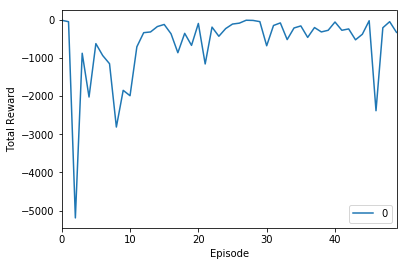

In [4]:
reward_result = pd.DataFrame(reward_record)
reward_result.plot()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()